# In this file we calibrate the rBergomi model with flat forward variance through the image based approach
In the forward pass we learn the **mapping** between **rBergomi parameters** and the entire implied volatility **surface**, which in this case is on a fixed grid 11(strikes)x8(maturities).  
Below we upload the dataset from Horvat, we will use the same notation for rBergomi parameters.

In [1]:
#Set the directory of stored dataset
import os
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/rBergomi/flat forward variance")

In [2]:
#import libraries
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#Open compressed dataset

f = gzip.GzipFile('rBergomiTrainSet.txt.gz',"r")
dat=np.load(f) #load data in a numpy array
xx=dat[:,:4]   #extract first 4 columns (rBergomi parameters)
yy=dat[:,4:]   #extract last  columns ()

#define strikes and maturities
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

# Print shapes with descriptive messages
print("Shape of the full dataset (samples × (parameters + implied_vols)):", dat.shape)
print("\nInput (rBergomi parameter sets) shape (samples × 4 parameters):", xx.shape)
print("  - Each row contains: [ξ₀, ν, ρ, H]")
print("\nTarget (Implied Volatility Surfaces) shape (samples × (maturities × strikes)):", yy.shape)
print(f"  - Each row represents a {len(maturities)}×{len(strikes)} grid (maturities × strikes)")

Shape of the full dataset (samples × (parameters + implied_vols)): (40000, 92)

Input (rBergomi parameter sets) shape (samples × 4 parameters): (40000, 4)
  - Each row contains: [ξ₀, ν, ρ, H]

Target (Implied Volatility Surfaces) shape (samples × (maturities × strikes)): (40000, 88)
  - Each row represents a 8×11 grid (maturities × strikes)


# Let's have a look at the dataset and gain some more informations


=== rBergomi PARAMETERS ANALYSIS (xx) ===
       ξ₀ (flat forward variance)  ν (influences smile)  \
count                  40000.0000            40000.0000   
mean                       0.0881                2.2073   
std                        0.0420                1.0571   
min                        0.0100                0.3000   
1%                         0.0124                0.3423   
5%                         0.0206                0.5130   
50%                        0.0888                2.2298   
95%                        0.1527                3.8239   
99%                        0.1585                3.9632   
max                        0.1600                4.0000   

       ρ (spot-vol correlation)  H (Hurst exponent)  
count                40000.0000          40000.0000  
mean                    -0.5159              0.2594  
std                      0.2406              0.1373  
min                     -0.9499              0.0250  
1%                      -0.9381      

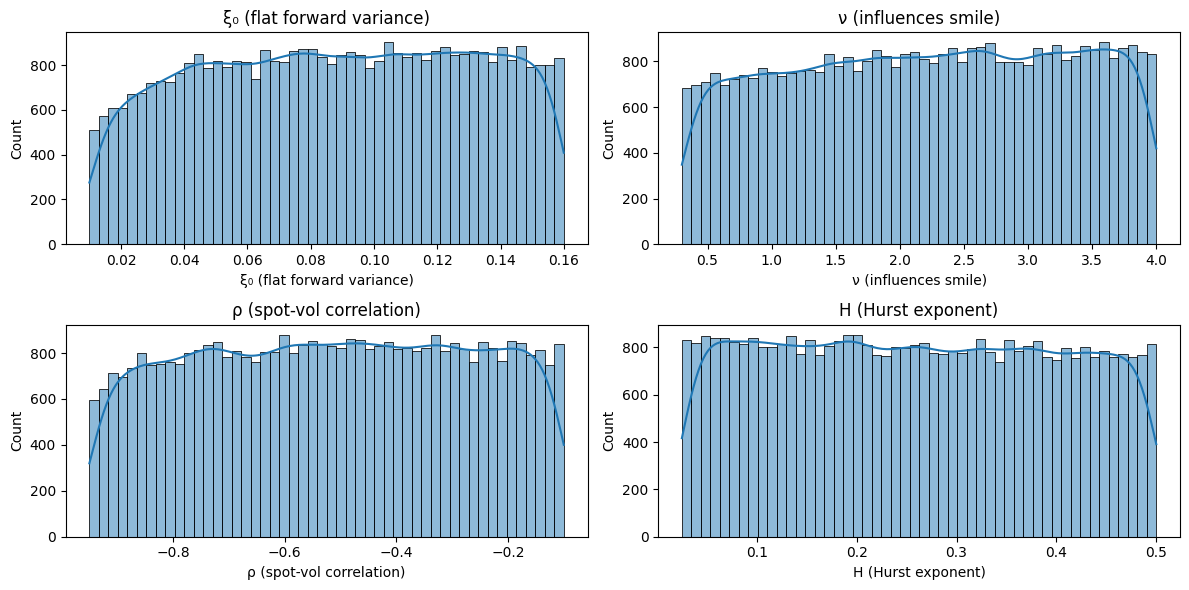


=== IMPLIED VOLATILITY SURFACE ANALYSIS (yy) ===
Global mean: 0.2706
Global min: 0.0278
Global max: 0.9660

Volatility matrix for strikes/maturities (first sample):
        0.5     0.6     0.7     0.8     0.9     1.0     1.1     1.2     1.3  \
0.1  0.7146  0.6159  0.5281  0.4438  0.3619  0.2831  0.2153  0.1901  0.2019   
0.3  0.6148  0.5270  0.4482  0.3754  0.3064  0.2402  0.1831  0.1610  0.1694   
0.6  0.5139  0.4408  0.3748  0.3135  0.2554  0.2000  0.1528  0.1346  0.1414   
0.9  0.4456  0.3821  0.3247  0.2715  0.2210  0.1731  0.1323  0.1167  0.1226   
1.2  0.3987  0.3417  0.2902  0.2424  0.1972  0.1544  0.1179  0.1041  0.1094   
1.5  0.3625  0.3105  0.2635  0.2201  0.1790  0.1400  0.1069  0.0944  0.0992   
1.8  0.3343  0.2862  0.2428  0.2027  0.1647  0.1288  0.0983  0.0868  0.0912   
2.0  0.3161  0.2707  0.2296  0.1916  0.1557  0.1217  0.0929  0.0820  0.0862   

        1.4     1.5  
0.1  0.2224  0.2426  
0.3  0.1854  0.2023  
0.6  0.1543  0.1680  
0.9  0.1338  0.1456  
1.2  0.1193 

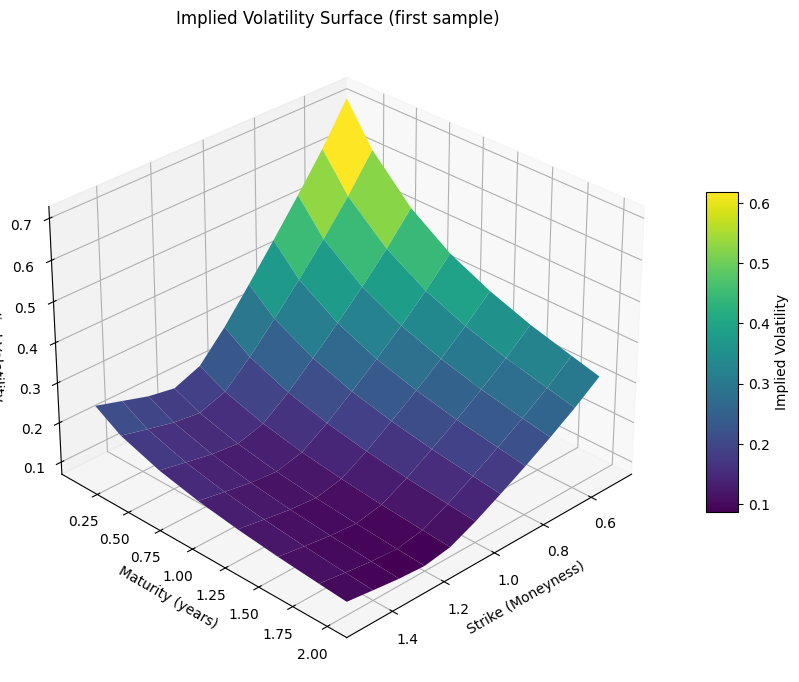

In [3]:
import seaborn as sns

#INPUT (rBergomi PARAMETERS) ANALYSIS 

# rBergomi parameter names (for clarity)
#ξ₀  ∈ [0.01, 0.16]        (flat forward variance)
#ν   ∈ [0.3, 4.0]          (influences smile)
#ρ   ∈ [-0.95, -0.1]       (spot-vol correlation)
#H   ∈ [0.025, 0.5]        (Hurst exponent)

param_names = [
    'ξ₀ (flat forward variance)',
    'ν (influences smile)',
    'ρ (spot-vol correlation)',
    'H (Hurst exponent)',
]


# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(xx, columns=param_names)

# Descriptive statistics
print("\n=== rBergomi PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ξ₀:    Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.01, 0.16])")
print(f"ρ:   Min={df_xx.iloc[:,2].min():.4f}, Max={df_xx.iloc[:,2].max():.4f} (Expected: ~[-0.95, -0.1])")
print(f"H: Min={df_xx.iloc[:,3].min():.4f}, Max={df_xx.iloc[:,3].max():.4f} (Expected: ~[0.025, 0.5])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

#OUTPUT (IMPLIED VOLATILTY SURFACE) ANALYSIS 
print("\n=== IMPLIED VOLATILITY SURFACE ANALYSIS (yy) ===")

# Global statistics
print(f"Global mean: {yy.mean():.4f}")
print(f"Global min: {yy.min():.4f}")
print(f"Global max: {yy.max():.4f}")

# Reshape first sample into strike/maturity matrix
vol_matrix = yy[0].reshape(len(maturities), len(strikes))
df_vol = pd.DataFrame(vol_matrix, index=maturities, columns=strikes)

print("\nVolatility matrix for strikes/maturities (first sample):")
print(df_vol.round(4))

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create grid for surface plot
X, Y = np.meshgrid(strikes, maturities)

# Plot surface
surf = ax.plot_surface(X, Y, vol_matrix, cmap='viridis', edgecolor='none')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Implied Volatility')

# Set labels and title
ax.set_xlabel('Strike (Moneyness)')
ax.set_ylabel('Maturity (years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface (first sample)')

# Adjust view angle for better visualization
ax.view_init(30, 45)

# Adjust layout to prevent clipping
plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

plt.show()

# Step 1: Data Generation


## **Inputs:** 
###  1. $\xi_{0}$ flat forward variance
###  2. $\nu$ smile effect
###  3. $\rho$ spot-vol correlation
###  4. $H$ Hurst exponent
    
    
## **Outputs:**
### Implied volatility surface (8x11=88 points)

# Scaling:

# Model Parameters ${\theta}_{i=1,..,4}\to scale(\theta_i)\in[-1,1]$
## $scale(\theta_i)=\frac{2\theta_i-(\theta_i^{max}+\theta_i^{min})}{\theta_i^{max}-\theta_i^{min}},\quad i \in |\Theta|$

# Implied volatilities
## $$scale(\sigma^{BS}_{i,j})=\frac{\sigma^{BS}_{i,j}-\mathbb{E}[\sigma^{BS}_{i,j}]}{std(\sigma^{BS}_{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [4]:
#Train+val(90%)-test(10%) split of data 
from sklearn.model_selection import train_test_split
from tabulate import tabulate

X_train_val, X_test, y_train_val, y_test = train_test_split(
    xx, yy, test_size=0.1, random_state=42)

#Train(85%)-val(15%) split of data 
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.11, random_state=42)

#data preprocessing (scaling)
from sklearn.preprocessing import StandardScaler

#1- Apply standard (z-score) scaling to target volatilities
#  to train, validation and test data (clearly without recomputing mu and sigma for validation and test data)
scaler_yy = StandardScaler()
y_train_transform = scaler_yy.fit_transform(y_train)  #we compute mu and sigma
y_val_transform = scaler_yy.transform(y_val)  
y_test_transform = scaler_yy.transform(y_test)

#define the inverse transform of data to bring volatilities back to original values
def yinversetransform(x):
    return scaler_yy.inverse_transform(x)

#2-Custom [-1,1] parameter scaling, define rBergomi parameter's upper and lower bounds
#ξ₀  ∈ [0.01, 0.16]        (flat forward variance)
#ν   ∈ [0.3, 4.0]          (influences smile)
#ρ   ∈ [-0.95, -0.1]       (spot-vol correlation)
#H   ∈ [0.025, 0.5]        (Hurst exponent)
#parameters order is: [ξ₀, ν, ρ, H]

ub=np.array([0.16,4.0,-0.1,0.5])
lb=np.array([0.01,0.3,-0.95,0.025])

#define the direct and inverse map (as described above)
def myscale(x):
    res=np.zeros(x.shape)
    for i in range(x.shape[1]):
        res[:,i]=(2*x[:,i] - (ub[i] + lb[i])) / (ub[i] - lb[i])
        
    return res

def myinverse(x):
    res=np.zeros(x.shape)
    for i in range(x.shape[1]):
        res[:,i]=x[:,i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5
        
    return res

#scale parameters in training, validation and test set
x_train_transform = myscale(X_train)
x_val_transform = myscale(X_val)
x_test_transform = myscale(X_test)

# Print dataset shapes in a table
shape_data = [
    ["Training", x_train_transform.shape, y_train_transform.shape],
    ["Validation", x_val_transform.shape, y_val_transform.shape],
    ["Test", x_test_transform.shape, y_test_transform.shape]
]

print("\nDataset Shapes Summary:")
print(tabulate(shape_data, 
               headers=["Dataset", "Input Features Shape", "Target Volatilities Shape"],
               tablefmt="grid"))


Dataset Shapes Summary:
+------------+------------------------+-----------------------------+
| Dataset    | Input Features Shape   | Target Volatilities Shape   |
+============+========================+=============================+
| Training   | (32040, 4)             | (32040, 88)                 |
+------------+------------------------+-----------------------------+
| Validation | (3960, 4)              | (3960, 88)                  |
+------------+------------------------+-----------------------------+
| Test       | (4000, 4)              | (4000, 88)                  |
+------------+------------------------+-----------------------------+


# Let's see if the scaling has been correctly applied

In [5]:
# ----------------------------------------------------------------------------------
# 1. Verify OUTPUT Scaling (yy: Implied Volatilities - StandardScaler)
# ----------------------------------------------------------------------------------
def check_yy_scaling(y_train, y_val, y_test, y_train_transform, y_val_transform, y_test_transform):
    # Calculate statistics for each set
    stats_train = {
        "Set": "Train",
        "Mean": np.mean(y_train_transform, axis=0).round(3)[0],
        "Std": np.std(y_train_transform, axis=0).round(3)[0],
        "Min": np.min(y_train_transform).round(3),
        "Max": np.max(y_train_transform).round(3),
        "Inverse Check": np.allclose(y_train, yinversetransform(y_train_transform))
    }
    
    stats_val = {
        "Set": "Validation",
        "Mean": np.mean(y_val_transform, axis=0).round(3)[0],
        "Std": np.std(y_val_transform, axis=0).round(3)[0],
        "Min": np.min(y_val_transform).round(3),
        "Max": np.max(y_val_transform).round(3),
        "Inverse Check": np.allclose(y_val, yinversetransform(y_val_transform))
    }
    
    stats_test = {
        "Set": "Test",
        "Mean": np.mean(y_test_transform, axis=0).round(3)[0],
        "Std": np.std(y_test_transform, axis=0).round(3)[0],
        "Min": np.min(y_test_transform).round(3),
        "Max": np.max(y_test_transform).round(3),
        "Inverse Check": np.allclose(y_test, yinversetransform(y_test_transform))
    }
    
    # Create table
    df_yy = pd.DataFrame([stats_train, stats_val, stats_test])
    print("\n=== IMPLIED VOLATILITIES SCALING (StandardScaler) ===")
    print(tabulate(df_yy, headers='keys', tablefmt='pretty', showindex=False))

# ----------------------------------------------------------------------------------
# 2. Verify INPUT Scaling (xx: rBergomi Parameters - Custom [-1,1])
# ----------------------------------------------------------------------------------
def check_xx_scaling(X_train, X_val, X_test, x_train_transform, x_val_transform, x_test_transform):
    # Parameter names
    param_names = ["ξ₀", "ν", "ρ", "H"]
    
    # Calculate min/max after scaling and check bounds
    data = {
        "Parameter": param_names,
        "Original Min": [X_train[:,i].min().round(4) for i in range(4)],
        "Original Max": [X_train[:,i].max().round(4) for i in range(4)],
        "Scaled Min (Train)": [x_train_transform[:,i].min().round(4) for i in range(4)],
        "Scaled Max (Train)": [x_train_transform[:,i].max().round(4) for i in range(4)],
    }
    
    df_xx = pd.DataFrame(data)
    print("\n=== rBergomi PARAMETERS SCALING (Custom [-1,1]) ===")
    print(tabulate(df_xx, headers='keys', tablefmt='pretty', showindex=False))
    
    print("\n=== VERIFY INVERSE TRANSFORMATION OF SCALED rBergomi PARAMETERS (xx) ===")
    print(f"Train: {np.allclose(X_train, myinverse(x_train_transform))}")
    print(f"Val:   {np.allclose(X_val, myinverse(x_val_transform))}")
    print(f"Test:  {np.allclose(X_test, myinverse(x_test_transform))}")

    # Global check: All scaled values must be in [-1, 1]
    assert np.all(x_train_transform >= -1) and np.all(x_train_transform <= 1), "Some values are outside [-1,1]!"
    print("\n✔ All scaled parameters are within [-1,1]")

# ----------------------------------------------------------------------------------
# Run checks
# ----------------------------------------------------------------------------------
check_yy_scaling(y_train, y_val, y_test, y_train_transform, y_val_transform, y_test_transform)
check_xx_scaling(X_train, X_val, X_test, x_train_transform, x_val_transform, x_test_transform)


=== IMPLIED VOLATILITIES SCALING (StandardScaler) ===
+------------+--------+-------+--------+-------+---------------+
|    Set     |  Mean  |  Std  |  Min   |  Max  | Inverse Check |
+------------+--------+-------+--------+-------+---------------+
|   Train    |  -0.0  |  1.0  | -3.735 | 3.058 |     True      |
| Validation | -0.013 | 0.993 | -3.406 | 3.039 |     True      |
|    Test    | -0.017 | 1.013 | -3.406 | 2.992 |     True      |
+------------+--------+-------+--------+-------+---------------+

=== rBergomi PARAMETERS SCALING (Custom [-1,1]) ===
+-----------+--------------+--------------+--------------------+--------------------+
| Parameter | Original Min | Original Max | Scaled Min (Train) | Scaled Max (Train) |
+-----------+--------------+--------------+--------------------+--------------------+
|    ξ₀     |     0.01     |     0.16     |      -0.9998       |        1.0         |
|     ν     |     0.3      |     4.0      |        -1.0        |        1.0         |
|     ρ

# CaNN: Calibration Neural Network
Step 1: *Forward Pass*
Now we can train the network to learn the **mapping** from: rBergomi parameters -> implied volatility surface. we can set up our neural network composed of:

- **4 hidden layers**, each with **30 neurons**  
- **output layer** with 8 x 11= 88 neurons (grid dimension), here we select a **linear** activation function because of the preprocessing of implied volatilities
- **Activation function**: **Elu** , $\sigma_{Elu}=\alpha(e^x -1)$ in all the layers, it's smoothness is crucial for the approximation of the Loss function
- **Batch size**: **256**  
- **Optimizer**: **Adam**  
- **Early stopping**: with patience set to 30 epochs, 400 max epochs
- **Loss**: MSE

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Set precision to float64
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(42)  # For consistent initialization

# Build the model
inputs = Input(shape=(4,), name='input_layer')
x1 = Dense(30, activation='elu', name='hidden_1')(inputs)
x2 = Dense(30, activation='elu', name='hidden_2')(x1) 
x3 = Dense(30, activation='elu', name='hidden_3')(x2) 
x4 = Dense(30, activation='elu', name='hidden_4')(x3)
outputs = Dense(88, activation='linear', name='output_layer')(x4)

modelGEN = Model(inputs=inputs, outputs=outputs, name = 'IV_model')
modelGEN.summary()

Model: "IV_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 30)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,668 (44.28 KB)

 Trainable params: 5,668 (44.28 KB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

Epoch 1/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6174 - val_loss: 0.0784
Epoch 2/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0597 - val_loss: 0.0300
Epoch 3/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260 - val_loss: 0.0186
Epoch 4/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0135
Epoch 5/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0100
Epoch 6/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 7/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 8/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 9/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 10/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 11/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 12/400
126/126 ━━━━━━━━━━━━━━━━━━━━

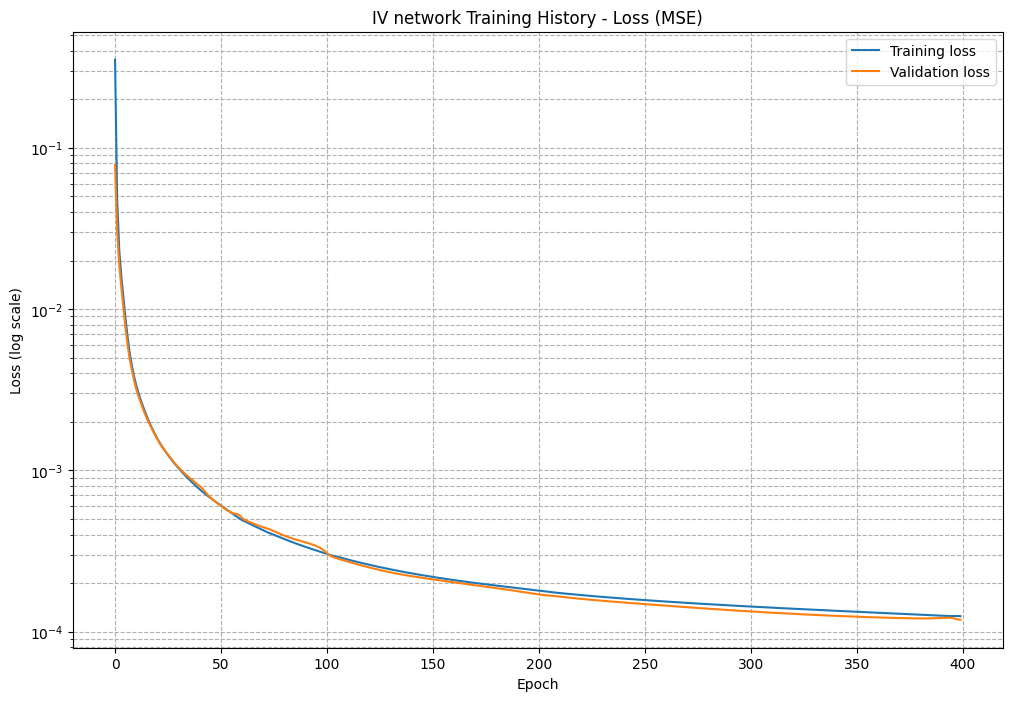


Final Training Loss: 1.2468e-04
Final Validation Loss: 1.1856e-04


In [7]:
import time
# EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss', 
    patience=30,       
    verbose=1,       
    restore_best_weights=True  # Restore the best model weights
)

# Callbacks
#reduce_lr = ReduceLROnPlateau(
#        monitor='val_loss',
#        factor=0.5,
#        patience=20,
#        min_lr=5e-5,
 #       verbose=1
 #   )

# Compile the model
modelGEN.compile(loss="mse", optimizer="adam")

# Train the model
start=time.time()
history = modelGEN.fit(
    x_train_transform, 
    y_train_transform, 
    batch_size=256,
    validation_data=(x_val_transform, y_val_transform),
    epochs=400, 
    verbose=1, 
    shuffle=True, 
    callbacks=[earlystop]
)
end=time.time()
training_time=(end-start)
print("Training time :" ,training_time , "s" )

# Plot training history
plt.figure(figsize=(12, 8))  
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.title('IV network Training History - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.4e}")
print(f"Final Validation Loss: {final_val_loss:.4e}")

# Evaluate the map on test data

In [8]:
# Calculate predictions on preprocessed test data
y_pred_transformed = modelGEN.predict(x_test_transform)

# 1) Error on preprocessed test data (y_test_transform)
mse_transformed = np.mean(np.square(y_test_transform - y_pred_transformed))
rmse_transformed = np.sqrt(mse_transformed)

print("\nErrors on preprocessed test data:")
print(f"- MSE: {mse_transformed:.6f}")
print(f"- RMSE: {rmse_transformed:.6f}")

# 2) Error on original scale test data (inverse transformed)
y_pred_original = yinversetransform(y_pred_transformed)

mse_original = np.mean(np.square(y_test - y_pred_original))
rmse_original = np.sqrt(mse_original)

print("\nErrors on original scale test data:")
print(f"- MSE: {mse_original:.7f}")
print(f"- RMSE: {rmse_original:.7f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Errors on preprocessed test data:
- MSE: 0.000121
- RMSE: 0.010983

Errors on original scale test data:
- MSE: 0.0000009
- RMSE: 0.0009433


# Optimizing the training
Numpy Implementation of the Neural Network tends to be faster than Keras

In [14]:
import scipy.optimize
import matplotlib.ticker as mtick

def extract_weights_from_keras_model(model):
    """
    Extract weights and bias from the trained keras network, format for Numpy usage
    """
    weights_and_biases = []
    
    # Extract weights and biases for every layer
    for layer in model.layers:
        if hasattr(layer, 'get_weights') and layer.get_weights():
            weights, biases = layer.get_weights()
            weights_and_biases.append([weights, biases])
    
    return weights_and_biases

NNParameters = extract_weights_from_keras_model(modelGEN)

# =====================================================================================
# NUMPY IMPLEMENTATION OF THE NN (FASTER THAN KERAS)
# =====================================================================================

# Network hyperparameters
NumLayers = 4  # 4 hidden layers
OutputSize = 88  # 88 ivs

def elu(x):
    """
    Elu activation function
    """
    ind = (x < 0)
    x[ind] = np.exp(x[ind]) - 1
    return x

def eluPrime(y):
    """
    ELU derivative
    """
    x = np.copy(y)
    ind = (x < 0)
    x[ind] = np.exp(x[ind])
    x[~ind] = 1
    return x

def NeuralNetwork(x):
    """
    Forward pass of NN
    Input: x - array of 4 scaled rBergomi parameters
    Output: array of 88 ivs
    """
    input1 = x.copy()
    
    # Hidden layers with Elu activation
    for i in range(NumLayers):
        input1 = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        input1 = elu(input1)
    
    # Output layer (linear)
    i += 1
    output = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
    
    return output

def NeuralNetworkGradient(x):
    """
    Compute network gradient w.r to rBergomi parameters
    Output: Jacobian of dimension (88, 4)
    """
    input1 = x.copy()
    
    # Identity matrix for initial Jacobian
    grad = np.eye(4)
    
    # Propagate gradient via chain rule
    for i in range(NumLayers):
        # Forward pass 
        z = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        
        # Update gradient
        grad = np.einsum('ij,jk->ik', grad, NNParameters[i][0])
        
        # Apply Elu derivative
        grad *= eluPrime(z)
        
        # Update input for next layer
        input1 = elu(z)
    
    # Output layer (lineare, nessuna attivazione)
    grad = np.einsum('ij,jk->ik', grad, NNParameters[i+1][0])
    
    return grad

# Complete test analysis

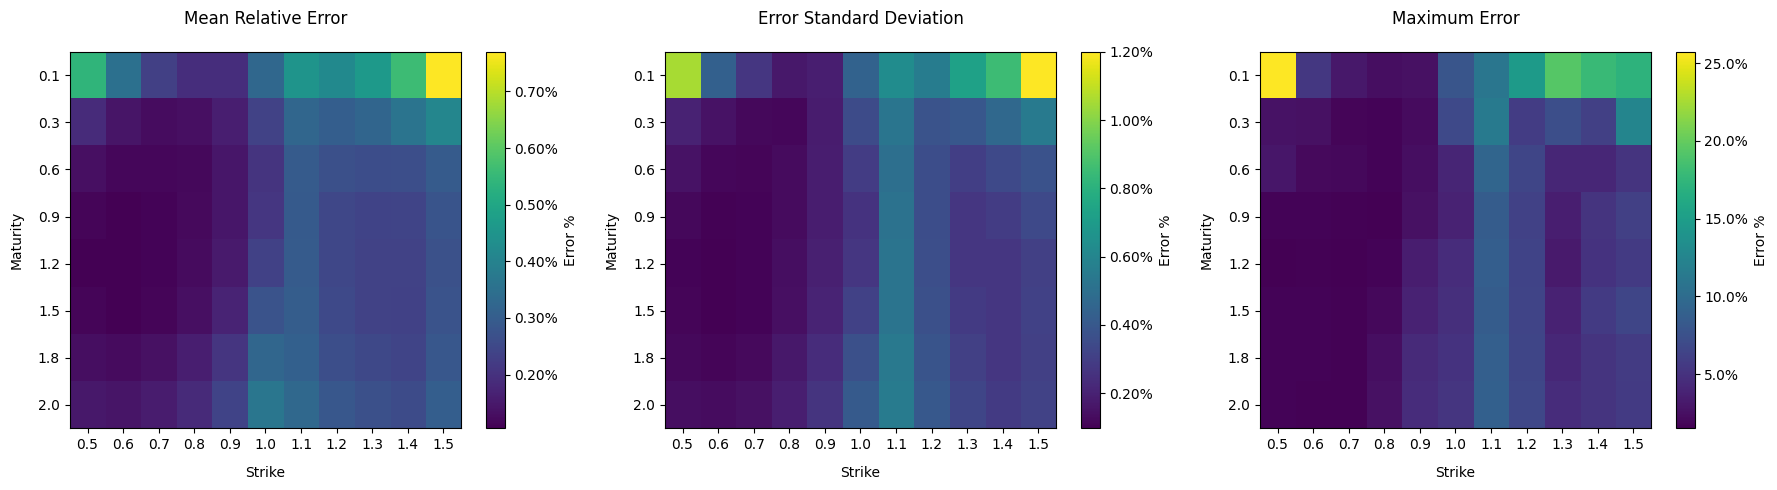

In [9]:
# 1. Generate predictions
#y_pred_transformed = modelGEN.predict(x_test_transform)  # Shape: (n_samples, 88)
#y_pred_original = yinversetransform(y_pred_transformed)  # Convert back to original volatility space

# 2. Calculate relative errors (percentage)
relative_errors = np.abs((y_test - y_pred_original) / y_test) * 100  # Shape: (n_samples, 88)

# 3. Reshape errors to (n_samples, 8 maturities, 11 strikes)
# Note: 88 = 8 maturities × 11 strikes, column-major order (maturities on rows, strikes on columns, in the vector of dimension 88 
# the first 11 implied volatilities refer to the SAME maturity (first), the next 11 iv to next maturity and so on)
relative_errors_reshaped = relative_errors.reshape(-1, len(maturities), len(strikes))

# 4. Create error plots
plt.figure(figsize=(18, 5))

# Plot 1: Mean Relative Error
plt.subplot(1, 3, 1)
mean_error = np.mean(relative_errors_reshaped, axis=0)  # Avg across samples
plt.imshow(mean_error, origin='upper', aspect='auto', cmap="viridis")
plt.colorbar(label='Error %', format=mtick.PercentFormatter())
plt.title("Mean Relative Error", pad=20)
plt.xlabel("Strike", labelpad=10)
plt.ylabel("Maturity", labelpad=10)
plt.xticks(np.arange(len(strikes)), [f"{s}" for s in strikes])
plt.yticks(np.arange(len(maturities)), [f"{m}" for m in maturities])

# Plot 2: Standard Deviation
plt.subplot(1, 3, 2)
std_error = np.std(relative_errors_reshaped, axis=0)
plt.imshow(std_error, origin='upper', aspect='auto', cmap="viridis")
plt.colorbar(label='Error %', format=mtick.PercentFormatter())
plt.title("Error Standard Deviation", pad=20)
plt.xlabel("Strike", labelpad=10)
plt.ylabel("Maturity", labelpad=10)
plt.xticks(np.arange(len(strikes)), [f"{s}" for s in strikes])
plt.yticks(np.arange(len(maturities)), [f"{m}" for m in maturities])

# Plot 3: Maximum Error
plt.subplot(1, 3, 3)
max_error = np.max(relative_errors_reshaped, axis=0)
plt.imshow(max_error, origin='upper', aspect='auto', cmap="viridis")
plt.colorbar(label='Error %', format=mtick.PercentFormatter())
plt.title("Maximum Error", pad=20)
plt.xlabel("Strike", labelpad=10)
plt.ylabel("Maturity", labelpad=10)
plt.xticks(np.arange(len(strikes)), [f"{s}" for s in strikes])
plt.yticks(np.arange(len(maturities)), [f"{m}" for m in maturities])

plt.tight_layout()
plt.show()

# Plot sample smiles

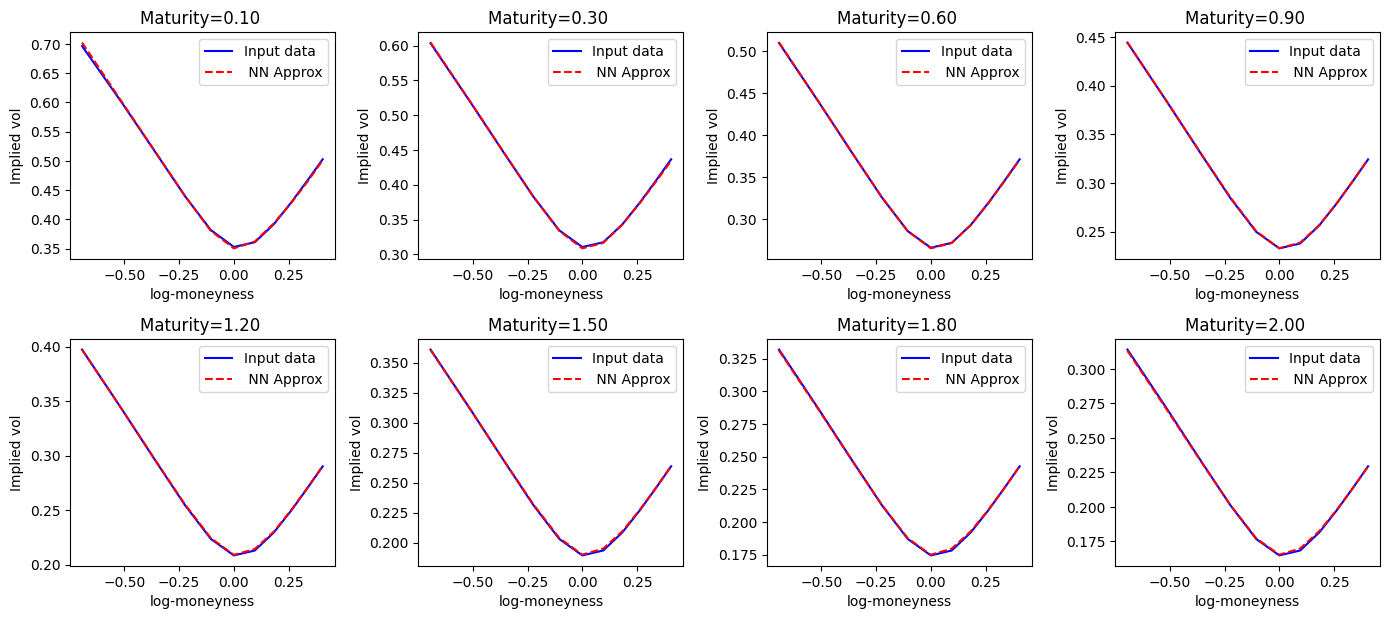

In [16]:
# Take a sample index from the test set
sample_ind = 512
y_sample = y_test[sample_ind]             #take corresponding (not processed)test sample
prediction = y_pred_original[sample_ind]  #take corresponding (converted)prediction

S0=1.0  #specify spot price
strikes_dim = len(strikes)

plt.figure(1,figsize=(14,12))
for i in range(len(maturities)):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

# Second part: Calibration
Step 2: *Backward Pass*
Now that we have trained the forward pass and learnt the map from rBergomi parameters to implied volatility surface we can calibrate online.

Below we'll exploit several gradient based methods:
We can now efficently and **quickly** calibrate the rBergomi parameters.

In [17]:
# Define loss functions.

#1. MSE
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-y_test_transform[sample_ind]),2))

#2. Compute gradient of cost function w.r. to parameters
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-y_test_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)

#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-y_test_transform[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

# scale back function for single parameter set
def max_min_scale_inverse(x):
 return x*(ub - lb)*0.5 + (ub + lb)*0.5

In [18]:
# =====================================================================================
# GRADIENT BASED CALIBRATION WITH DIFFERENT ALGORITHMS
# =====================================================================================

# Initialize arrays for results
solutions = np.zeros([4, 4])  # 4 methods, 4 parameters
times = np.zeros(4)

Approx = []
Timing = []

methods = ["L-BFGS-B", "SLSQP", "BFGS", "Levenberg-Marquardt"]
init = np.zeros(4)  # Initial guess for optimization

# Calibrate all surfaces in y_test
for i in range(y_test_transform.shape[0]):
    disp = str(i+1) + "/" + str(len(y_test))
    print(disp, end="\r")
    
    # L-BFGS-B
    start = time.perf_counter()
    res = scipy.optimize.minimize(
        CostFunc, 
        x0=init, 
        args=(i,), 
        method='L-BFGS-B', 
        jac=Jacobian, 
        tol=1e-10,
        options={"maxiter": 5000}
    )
    end = time.perf_counter()
    solutions[0, :] = max_min_scale_inverse(res.x)
    times[0] = end - start
    
    # SLSQP
    start = time.perf_counter()
    res = scipy.optimize.minimize(
        CostFunc, 
        x0=init, 
        args=(i,), 
        method='SLSQP', 
        jac=Jacobian, 
        tol=1e-10,
        options={"maxiter": 5000}
    )
    end = time.perf_counter()
    solutions[1, :] = max_min_scale_inverse(res.x)
    times[1] = end - start
    
    # BFGS
    start = time.perf_counter()
    res = scipy.optimize.minimize(
        CostFunc, 
        x0=init, 
        args=(i,), 
        method='BFGS', 
        jac=Jacobian, 
        tol=1e-10,
        options={"maxiter": 5000}
    )
    end = time.perf_counter()
    solutions[2, :] = max_min_scale_inverse(res.x)
    times[2] = end - start
    
    # Levenberg-Marquardt
    start = time.perf_counter()
    res = scipy.optimize.least_squares(
        CostFuncLS, 
        init, 
        JacobianLS, 
        args=(i,), 
        gtol=1e-10
    )
    end = time.perf_counter()
    solutions[3, :] = max_min_scale_inverse(res.x)
    times[3] = end - start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))

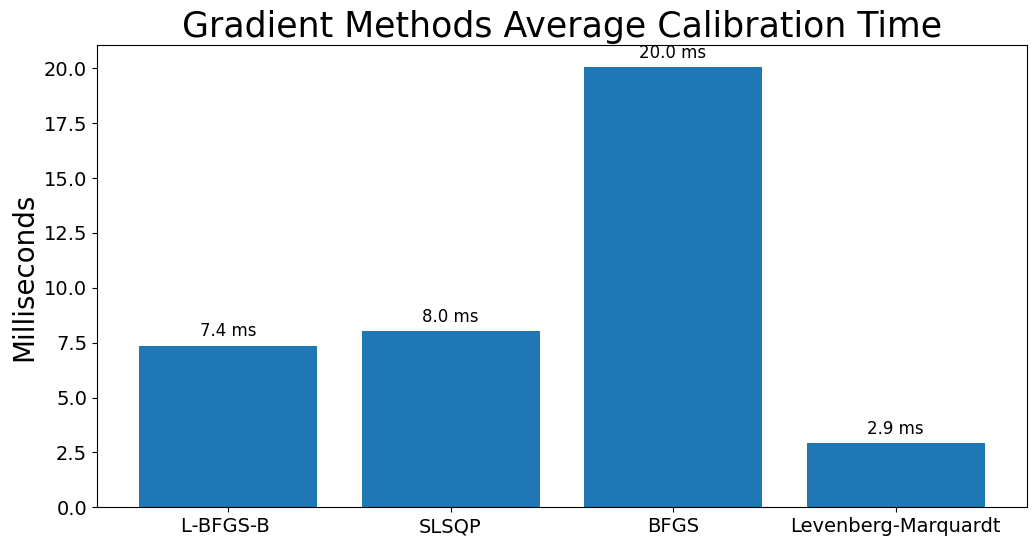

In [19]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Plot average calibration times
methods = ["L-BFGS-B ", "SLSQP", "BFGS", "Levenberg-Marquardt"]

# Calculate average times in milliseconds
avg_times_ms = np.mean(Timing, axis=0) * 1000

# Plot settings
plt.figure(1, figsize=(12, 6))
bars = plt.bar(methods, avg_times_ms)

# Add exact numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.25,
             f'{height:.1f} ms',
             ha='center', va='bottom', fontsize=12)
             
plt.title("Gradient Methods Average Calibration Time", fontsize=25)
plt.ylabel("Milliseconds", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

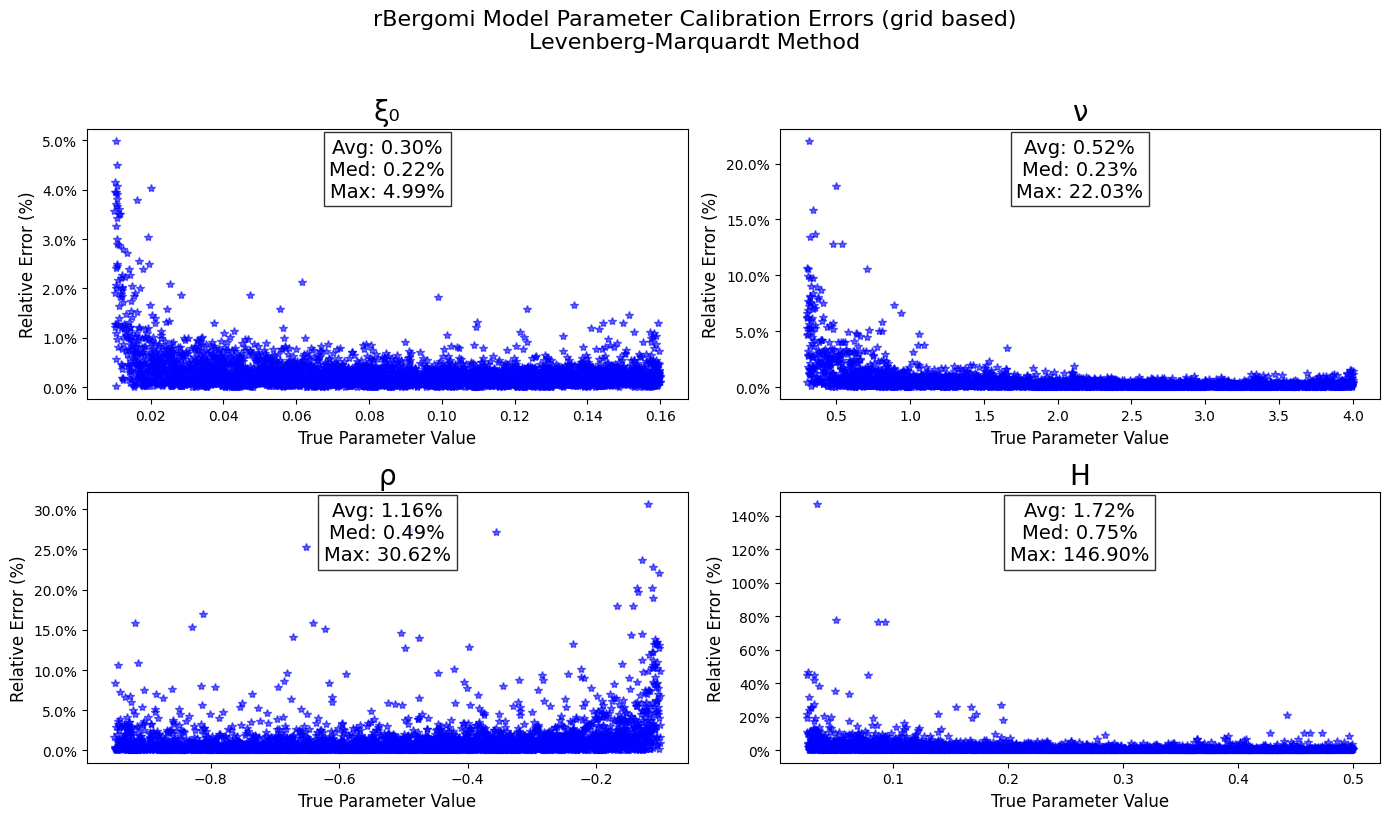


Summary Statistics of Relative Errors (%):
ξ₀: Avg=0.30%, Med=0.22%, Max=4.99%
ν: Avg=0.52%, Med=0.23%, Max=22.03%
ρ: Avg=1.16%, Med=0.49%, Max=30.62%
H: Avg=1.72%, Med=0.75%, Max=146.90%


In [20]:
# Extract Levenberg-Marquardt parameters (usually the best performing)
LMParameters = np.array([Approx[i][3] for i in range(len(Approx))])  # Ensure numpy array

# Verify dimensions
assert len(LMParameters) == len(X_test), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["ξ₀", "ν", "ρ", "H"]
relative_errors = np.zeros((len(LMParameters), 4))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate relative errors 
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rBergomi Model Parameter Calibration Errors (grid based)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

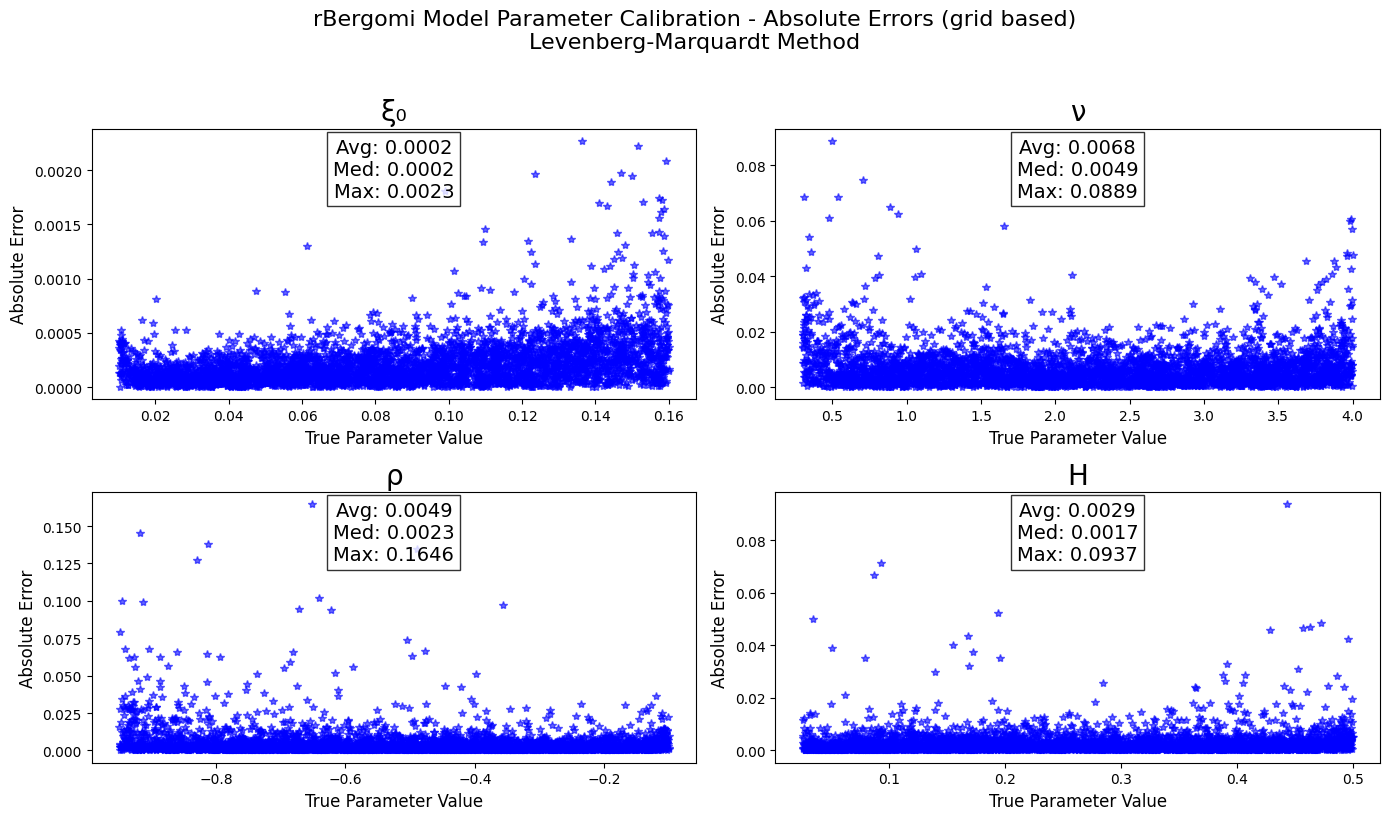


Summary Statistics of Absolute Errors:
ξ₀: Avg=0.000216, Med=0.000165, Max=0.002269
ν: Avg=0.006756, Med=0.004892, Max=0.088854
ρ: Avg=0.004861, Med=0.002282, Max=0.164603
H: Avg=0.002864, Med=0.001729, Max=0.093689


In [21]:
# Correct parameter names and absolute error analysis
titles = ["ξ₀", "ν", "ρ", "H"]
absolute_errors = np.zeros((len(LMParameters), 4))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rBergomi Model Parameter Calibration - Absolute Errors (grid based)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")

# Gradient-free optimization
And here we will exploit 3 different gradient free optimization methods: **COBYLA**, **Differential Evolution** and **Nelder-Mayer**.
We will use this configuration of parameters for these algorithms and compare both accuracy and calibration time.

In [22]:
# =====================================================================================
# GRADIENT-FREE CALIBRATION WITH DIFFERENT ALGORITHMS
# =====================================================================================

# Define loss functions (only cost function needed for gradient-free methods), they're the same as gradient one, but clearly don't require the Jacobian
# Define parameter bounds in scaled space [-1, 1] for all parameters
bounds_scaled = [(-1, 1) for _ in range(4)]

# =====================================================================================
# GRADIENT-FREE CALIBRATION WITH DIFFERENT ALGORITHMS
# =====================================================================================

# Initialize arrays for results
solutions = np.zeros([3, 4])  # 3 methods, 4 parameters
times = np.zeros(3)

Approx_GF = []  # GF = Gradient-Free
Timing_GF = []

methods = ["COBYLA", "Differential Evolution", "Nelder-Mead"]
init = np.zeros(4)  # Initial guess for optimization (scaled space)

print("Starting Gradient-Free Calibration...")
print(f"Total samples to calibrate: {y_test_transform.shape[0]}")

# Calibrate all surfaces in test set
for i in range(y_test_transform.shape[0]):
    disp = str(i+1) + "/" + str(y_test_transform.shape[0])
    print(disp, end="\r")
    
    # COBYLA (Constrained Optimization BY Linear Approximation)
    start = time.perf_counter()
    res = scipy.optimize.minimize(
        CostFunc, 
        x0=init, 
        args=(i,), 
        method='COBYLA',
        bounds=bounds_scaled,
        options={
            "maxiter": 5000,
            "disp": False,
            "catol": 1e-8,  # Constraint absolute tolerance
            "tol": 1e-10    # Function tolerance
        }
    )
    end = time.perf_counter()
    solutions[0, :] = max_min_scale_inverse(res.x)
    times[0] = end - start
    
    # Differential Evolution
    start = time.perf_counter()
    res = scipy.optimize.differential_evolution(
        CostFunc, 
        bounds=bounds_scaled,
        args=(i,), 
        popsize=50,          # Population size
        strategy='best1bin',  # Strategy
        mutation=0.65,       # Mutation factor
        recombination=0.7,   # Crossover recombination probability
        tol=0.01,           # Convergence tolerance
        maxiter=1000,       # Maximum iterations
        disp=False,
        seed=42             # For reproducibility
    )
    end = time.perf_counter()
    solutions[1, :] = max_min_scale_inverse(res.x)
    times[1] = end - start
    
    # Nelder-Mead (Simplex method)
    start = time.perf_counter()
    res = scipy.optimize.minimize(
        CostFunc, 
        x0=init, 
        args=(i,), 
        method='Nelder-Mead',
        options={
            "maxiter": 5000,
            "maxfev": 10000,    # Maximum function evaluations
            "disp": False,
            "xatol": 1e-8,      # Absolute error in parameters
            "fatol": 1e-10,     # Absolute error in function value
            "adaptive": True    # Adaptive algorithm parameters
        }
    )
    end = time.perf_counter()
    solutions[2, :] = max_min_scale_inverse(res.x)
    times[2] = end - start
    
    Approx_GF.append(np.copy(solutions))
    Timing_GF.append(np.copy(times))

print("\nGradient-Free Calibration completed!")

Starting Gradient-Free Calibration...
Total samples to calibrate: 4000
4000/4000
Gradient-Free Calibration completed!


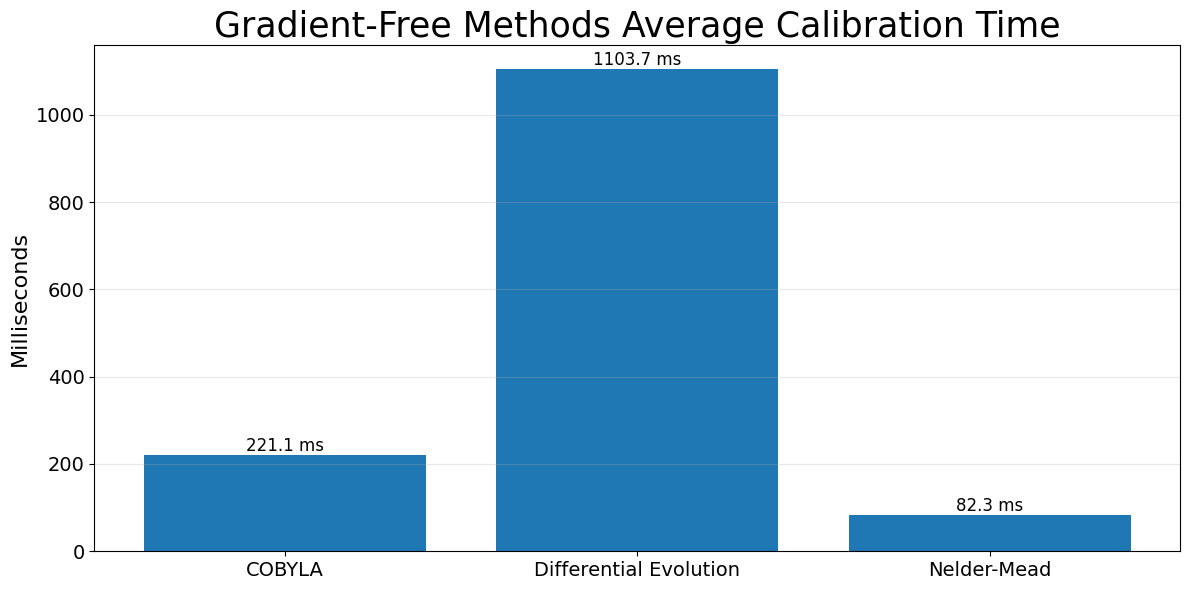

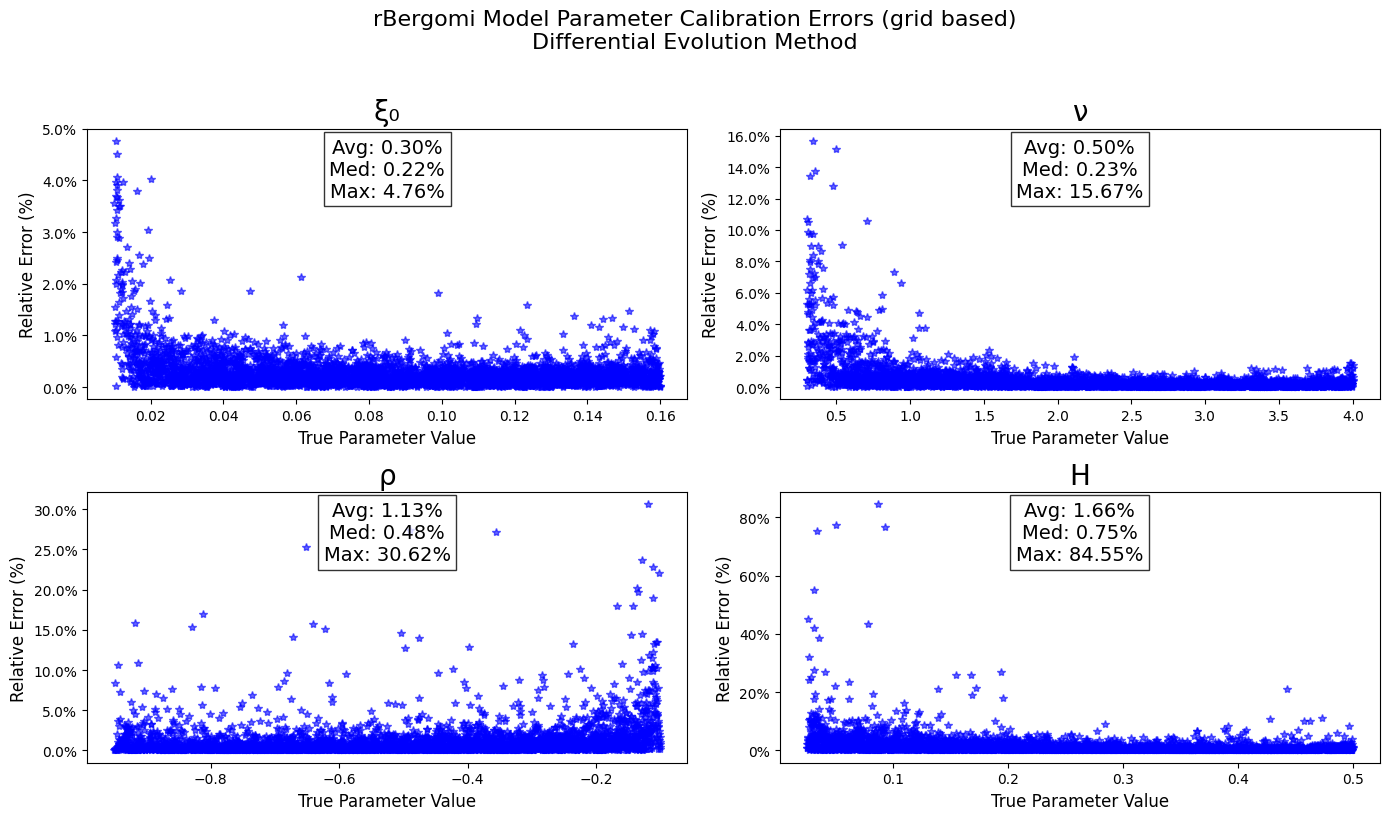


Summary Statistics of Relative Errors (%):
ξ₀: Avg=0.30%, Med=0.22%, Max=4.76%
ν: Avg=0.50%, Med=0.23%, Max=15.67%
ρ: Avg=1.13%, Med=0.48%, Max=30.62%
H: Avg=1.66%, Med=0.75%, Max=84.55%


In [24]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Plot average calibration times
methods_display = ["COBYLA", "Differential Evolution", "Nelder-Mead"]
plt.figure(figsize=(12, 6))
mean_times_ms = np.mean(Timing_GF, axis=0) * 1000  # Convert to milliseconds
bars = plt.bar(methods_display, mean_times_ms)
plt.title("Gradient-Free Methods Average Calibration Time", fontsize=25)
plt.ylabel("Milliseconds", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.25,
             f'{height:.1f} ms',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Analyze Gradient-Free optimization results (Differential Evolution)
DEParameters = np.array([Approx_GF[i][1] for i in range(len(Approx_GF))])  # DE is index 1

# Verify dimensions
assert len(DEParameters) == len(X_test), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["ξ₀", "ν", "ρ", "H"]
relative_errors = np.zeros((len(DEParameters), 4))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test[:len(DEParameters), param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate relative errors
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot with consistent style
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics - matching gradient-based version
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rBergomi Model Parameter Calibration Errors (grid based)\nDifferential Evolution Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis with same format
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

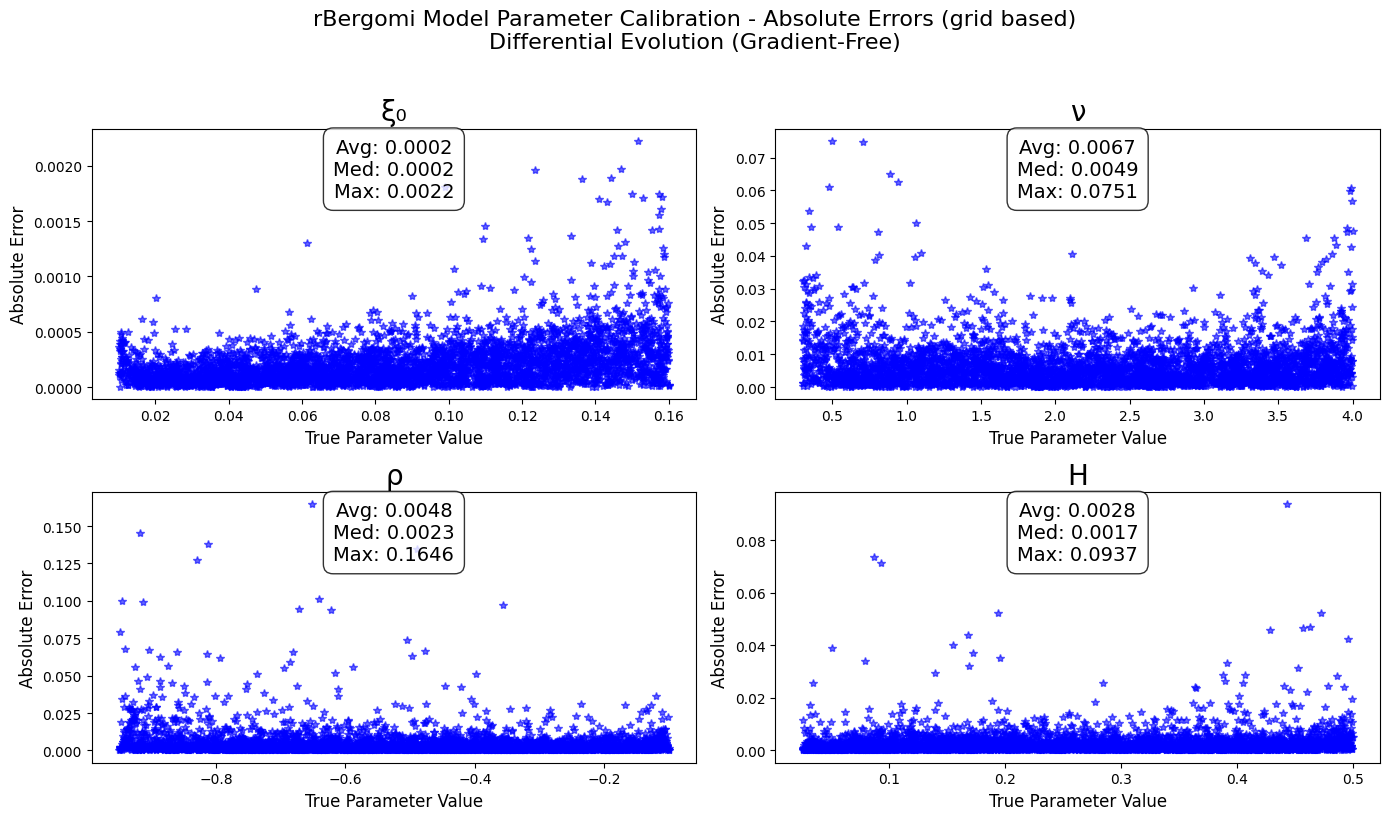


Summary Statistics of Absolute Errors:
ξ₀: Avg=0.000214, Med=0.000165, Max=0.002225
ν: Avg=0.006671, Med=0.004878, Max=0.075124
ρ: Avg=0.004780, Med=0.002262, Max=0.164601
H: Avg=0.002839, Med=0.001718, Max=0.093690


In [25]:
# Plot absolute errors for each parameter
titles = ["ξ₀", "ν", "ρ", "H"]
absolute_errors = np.zeros((len(DEParameters), 4))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test[:len(DEParameters), param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot with consistent style
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics with consistent formatting
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8,
                      boxstyle='round,pad=0.5'))

plt.suptitle('rBergomi Model Parameter Calibration - Absolute Errors (grid based)\nDifferential Evolution (Gradient-Free)', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis with consistent output format
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")

In [26]:
# =====================================================================================
# COMPREHENSIVE PERFORMANCE COMPARISON
# =====================================================================================

print("\n" + "="*70)
print("GRADIENT-FREE CALIBRATION PERFORMANCE SUMMARY")
print("="*70)

# Timing comparison
print("\nTiming Comparison (Average per calibration):")
for i, method in enumerate(methods_display):
    avg_time = np.mean(Timing_GF, axis=0)[i]
    print(f"{method:20s}: {avg_time*1000:8.2f} ms")

print("\nRelative Error Statistics for Differential Evolution:")
print("-" * 60)
for i, (title, param_name) in enumerate(zip(titles, titles)):
    errors = 100 * relative_errors[:, i]
    print(f"{param_name:20s} ({title}): Avg={np.mean(errors):6.2f}% | "
          f"Med={np.median(errors):6.2f}% | Std={np.std(errors):6.2f}% | "
          f"Max={np.max(errors):6.2f}%")

# Overall performance metrics
overall_avg_error = np.mean(100 * relative_errors)
overall_med_error = np.median(100 * relative_errors.flatten())
print("\nOverall Performance:")
print(f"Average relative error across all parameters: {overall_avg_error:.2f}%")
print(f"Median relative error across all parameters:  {overall_med_error:.2f}%")

# Success rate (define success as relative error < 5%)
success_rate = np.mean(relative_errors < 0.05) * 100
print(f"Success rate (relative error < 5%):           {success_rate:.1f}%")
print("="*70)


GRADIENT-FREE CALIBRATION PERFORMANCE SUMMARY

Timing Comparison (Average per calibration):
COBYLA              :   221.13 ms
Differential Evolution:  1103.72 ms
Nelder-Mead         :    82.27 ms

Relative Error Statistics for Differential Evolution:
------------------------------------------------------------
ξ₀                   (ξ₀): Avg=  0.30% | Med=  0.22% | Std=  0.38% | Max=  4.76%
ν                    (ν): Avg=  0.50% | Med=  0.23% | Std=  1.05% | Max= 15.67%
ρ                    (ρ): Avg=  1.13% | Med=  0.48% | Std=  2.08% | Max= 30.62%
H                    (H): Avg=  1.66% | Med=  0.75% | Std=  3.78% | Max= 84.55%

Overall Performance:
Average relative error across all parameters: 0.90%
Median relative error across all parameters:  0.34%
Success rate (relative error < 5%):           97.2%
